In [33]:
import pandas as pd

def filter_data():
    # Read the data from ../data/raw/overall_filtered_us_data.csv
    data = pd.read_csv('../data/raw/overall_filtered_us_data.csv', low_memory=False)

    # Read the user ids from ../data/processed/combined_data.csv
    user_ids = pd.read_csv('../data/processed/combined_data.csv')['user']

    # Filter the data to only include rows with user ids present in combined_data.csv
    data = data[data['unique_id'].isin(user_ids)]

    # Read the question codes from ../data/raw/question_codes.json
    question_codes = pd.read_json('../data/raw/question_codes.json')['code']
    columns_to_keep = ['unique_id'] + list(question_codes)
    data = data[columns_to_keep]

    data.set_index('unique_id', inplace=True)
    data.drop(["F2A14", 'F1A9_1', 'F1A13_1', 'F1A16_1', 'F2A8', 'F3A5_1'], axis=1, inplace=True)

    return data

filtered_data = filter_data()




In [34]:
filtered_data.head() 

,F1A10_1,F2A6,F2A7,F2A9,F3A3_1,F3A6_1,F3A7_1,F3A8_1
unique_id,,,,,,,,
IDUS103408,2,3,3,2,6,4,4,7
IDUS103554,7,5,2,5,7,1,1,1
IDUS103826,4,1,1,4,7,1,3,4
IDUS104424,5,4,3,4,7,1,2,2
IDUS104578,6,5,2,4,6,1,3,2


In [35]:
filtered_data.to_csv('../data/raw/filtered_data.csv')

In [36]:
import pandas as pd
import json

def transform_data_with_question_codes(filtered_data_path, question_codes_path):
    """
    Transforms the filtered data by replacing question codes with actual question text
    and answer values with the corresponding answer text based on the question_codes.json file.

    Parameters:
    filtered_data_path (str): Path to the CSV file with the filtered data.
    question_codes_path (str): Path to the question_codes.json file.

    Returns:
    pd.DataFrame: A transformed DataFrame with question text as column headers and answer text as values.
    """

    # Load the filtered data
    filtered_data = pd.read_csv(filtered_data_path)

    # Load the question_codes.json file
    with open(question_codes_path) as f:
        question_data = json.load(f)

    # Create mappings for question codes to question text
    code_to_question = {item['code']: item['question'] for item in question_data}

    # Create mappings for each question's options
    code_to_options = {item['code']: item['options'] for item in question_data}

    # Step 1: Rename the columns using the question text
    filtered_data.rename(columns=code_to_question, inplace=True)

    # Step 2: Replace the values with the answer text
    for code, options in code_to_options.items():
        question_text = code_to_question.get(code)  # Get the question text mapped to this code
        if question_text in filtered_data.columns:
            # Convert numeric responses to strings before mapping
            filtered_data[question_text] = filtered_data[question_text].astype(str).map(options)

    return filtered_data


In [37]:
encoded_data_path = '../data/raw/filtered_data.csv'
question_codes_path = '../data/raw/question_codes.json'
decoded_data = transform_data_with_question_codes(encoded_data_path, question_codes_path)

### Actual Human Responses

In [38]:
decoded_data.head()

,unique_id,I feel like I am treated fairly by politicians.,To what degree does this concern you: The fact that the US is getting more deeply involved in the war in Ukraine,To what degree does this concern you: The situation of Ukrainian refugees in the US,To what degree does this concern you: The state of the US healthcare system,"Agree or disagree: In the US, you can express your opinion publicly without fear of hostility",Agree or disagree: We no longer have room in the US for refugees from countries other than Ukraine,Agree or disagree: Foreigners exacerbate crime problems,Agree or disagree: Foreigners are taking jobs away from Americans
0,IDUS103408,Agree,moderately concerned,moderately concerned,not very concerned,Disagree,Neither agree nor disagree,Neither agree nor disagree,Completely disagree
1,IDUS103554,Completely disagree,very concerned,not very concerned,very concerned,Completely disagree,Completely agree,Completely agree,Completely agree
2,IDUS103826,Neither agree nor disagree,not concerned at all,not concerned at all,quite concerned,Completely disagree,Completely agree,Agree to some extent,Neither agree nor disagree
3,IDUS104424,Disagree to some extent,quite concerned,moderately concerned,quite concerned,Completely disagree,Completely agree,Agree,Agree
4,IDUS104578,Disagree,very concerned,not very concerned,quite concerned,Disagree,Completely agree,Agree to some extent,Agree


### Generating Prompts For the LLMs 
(Based on the questions asked to the real people)

In [39]:
def generate_prompts_from_questions(question_codes_path):
    """
    Generates prompt strings for each question and its corresponding options from the question_codes.json file,
    excluding questions with specific codes.

    Parameters:
    question_codes_path (str): Path to the question_codes.json file.

    Returns:
    List[str]: A list of formatted prompts, each containing the question and its available options.
    """

    # List of question codes to exclude
    excluded_codes = ["F2A14", 'F1A9_1', 'F1A13_1', 'F1A16_1', 'F2A8', 'F3A5_1']

    # Load the question_codes.json file
    with open(question_codes_path) as f:
        question_data = json.load(f)

    prompts = []

    # Loop over each question in the JSON data
    for item in question_data:
        question_code = item.get('code')  # Assuming each question has a 'code' key
        question = item['question']
        options = item['options']

        # Skip questions whose codes are in the excluded list
        if question_code in excluded_codes:
            print(f"Skipping question with code: {question_code}")
            continue

        # Format the question and options as a readable string (no numbers involved)
        prompt = f"Based on your background and beliefs as described, respond to this question by selecting ONLY ONE of the provided options. Any answer not using exactly one of these options will be considered invalid.\n**Question**: {question}\n**Options** (choose ONE):\n"
        for option_text in options.values():
            prompt += f"- {option_text}\n"

        prompts.append(prompt.strip())  # Add the formatted prompt to the list

    return prompts


In [40]:
prompts = generate_prompts_from_questions(question_codes_path)
prompts[:5]

Skipping question with code: F1A9_1
Skipping question with code: F1A13_1
Skipping question with code: F1A16_1
Skipping question with code: F2A8
Skipping question with code: F2A14
Skipping question with code: F3A5_1


['Based on your background and beliefs as described, respond to this question by selecting ONLY ONE of the provided options. Any answer not using exactly one of these options will be considered invalid.\n**Question**: I feel like I am treated fairly by politicians.\n**Options** (choose ONE):\n- Completely agree\n- Agree\n- Agree to some extent\n- Neither agree nor disagree\n- Disagree to some extent\n- Disagree\n- Completely disagree',
 'Based on your background and beliefs as described, respond to this question by selecting ONLY ONE of the provided options. Any answer not using exactly one of these options will be considered invalid.\n**Question**: To what degree does this concern you: The fact that the US is getting more deeply involved in the war in Ukraine\n**Options** (choose ONE):\n- not concerned at all\n- not very concerned\n- moderately concerned\n- quite concerned\n- very concerned',
 'Based on your background and beliefs as described, respond to this question by selecting ON

### LLM Responses (Before exposure to biased articles)

In [41]:
def save_responses_to_file(output_file, responses):
    """
    Saves the list of responses to a JSON file.
    If the file exists, it appends the new responses to the existing data.
    """
    try:
        with open(output_file, 'r') as file:
            existing_data = json.load(file)
            responses = existing_data + responses
    except FileNotFoundError:
        pass  # If the file doesn't exist, we will create it later

    with open(output_file, 'w') as outfile:
        json.dump(responses, outfile, indent=4)


In [42]:
import logging
import re

class CustomOutputParser:
    def __init__(self):
        # Combined list of all predefined options, sorted by length (longest first to avoid partial matches)
        self.target_keys = sorted([
            # Agreement options
            'Completely agree', 'Agree', 'Agree to some extent', 'Neither agree nor disagree',
            'Disagree to some extent', 'Disagree', 'Completely disagree',
            # Concern levels
            'not concerned at all', 'not very concerned', 'moderately concerned',
            'quite concerned', 'very concerned'
        ], key=len, reverse=True)  # Sort by length to prioritize longer options

    def parse(self, output: str) -> dict:
        try:
            # Attempt to extract the exact option
            selected_option = self.extract_option(output)
            logging.debug(f"Extracted option: {selected_option}")

            # Handle case when no valid option is found
            if selected_option is None:
                logging.warning("No valid option found in the output.")
                selected_option = "N/A"

            return {
                "type": "final_answer",
                "selected_option": selected_option.strip()
            }
        except Exception as e:
            logging.error(f"Error parsing LLM output: {e}")
            return {"type": "raw_output", "content": output.strip()}

    def extract_option(self, text: str) -> str:
        # Normalize the text (remove extra spaces, lowercase for comparison)
        normalized_text = text.strip().lower()

        # Check for exact matches of predefined options in the raw output
        for option in self.target_keys:
            # Use word boundaries to ensure we're matching the whole phrase
            pattern = re.compile(r'\b' + re.escape(option.lower()) + r'\b')
            if pattern.search(normalized_text):
                return option  # Return the exact matched option

        # No valid option found
        return None

# Ensure logging is set up to show debug information
logging.basicConfig(level=logging.DEBUG)


In [43]:
import json
import os
from before_responses import load_persona_prompts
from llm import CustomLLM

def load_processed_responses(output_file):
    """ Load the already processed responses from the file. """
    processed_responses = {}
    
    if os.path.exists(output_file):
        with open(output_file, 'r') as f:
            try:
                existing_data = json.load(f)
                # Ensure the file contains a list of responses
                if isinstance(existing_data, list):
                    for response_data in existing_data:
                        user_id = response_data.get('user_id')
                        question = response_data.get('question')

                        if user_id and question:
                            if user_id not in processed_responses:
                                processed_responses[user_id] = set()
                            processed_responses[user_id].add(question)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}. Skipping invalid data in {output_file}.")
    
    return processed_responses

def append_responses_to_file(output_file, user_responses):
    """ Append the user responses to the output file, ensuring correct JSON formatting. """
    if os.path.exists(output_file):
        try:
            with open(output_file, 'r+') as f:
                try:
                    existing_data = json.load(f)
                    if not isinstance(existing_data, list):
                        print(f"Error: {output_file} contains invalid JSON format. Overwriting with new data.")
                        existing_data = []
                except json.JSONDecodeError:
                    print(f"Error: {output_file} contains invalid JSON. Overwriting with new data.")
                    existing_data = []
                
                # Append new responses to the existing data
                existing_data.extend(user_responses)
                
                # Move file pointer to the beginning to overwrite
                f.seek(0)
                json.dump(existing_data, f, indent=4)
                f.truncate()  # Ensure no leftover content
        except IOError as e:
            print(f"Error writing to file {output_file}: {e}")
    else:
        # If the file doesn't exist, create it and write the responses
        with open(output_file, 'w') as f:
            json.dump(user_responses, f, indent=4)

def get_agents_responses():
    # Load persona prompts
    persona_prompts = load_persona_prompts('../data/processed/persona_prompts.json')

    # Load the new question prompts
    question_prompts = generate_prompts_from_questions('../data/raw/question_codes.json')

    # Initialize the LLM and output parser
    llm = CustomLLM(model="llama3.1:70b-instruct-q6_K", api_url="https://inf.cl.uni-trier.de/")
    parser = CustomOutputParser()

    # Load previously processed responses
    output_file = '../data/processed/before_responses.json'
    processed_responses = load_processed_responses(output_file)

    # Iterate through persona prompts and new question prompts
    for persona in persona_prompts:
        persona_prompt = persona["persona_prompt"]
        user_id = persona["user_id"]

        # Check if the user has been processed before
        if user_id not in processed_responses:
            processed_responses[user_id] = set()

        user_responses = []

        for question_prompt in question_prompts:
            # Skip if this user-question pair has already been processed
            if question_prompt in processed_responses[user_id]:
                print(f"Skipping already processed User ID: {user_id}, Question: {question_prompt}")
                continue

            # Send persona prompt and question prompt to LLM
            response = llm.generate_response(persona_prompt, question_prompt)
            parsed_output = parser.parse(response)
            
            # Output the raw and parsed response for inspection
            print(f"User ID: {user_id}")
            print("Raw output:")
            print(response)
            print("Parsed output:")
            print(parsed_output)

            # Collect the responses for the current user
            user_responses.append({
                "user_id": user_id,
                "question": question_prompt,
                "response": parsed_output
            })
            # Mark this question as processed for this user
            processed_responses[user_id].add(question_prompt)
        
        # Append the user responses to the file after each user is processed
        append_responses_to_file(output_file, user_responses)


In [44]:
#get_agents_responses()


### Save Before Responses

In [45]:
import json

# Load the LLM responses from the file
llm_responses_path = '../data/processed/before_responses.json'  # Update with the correct path

with open(llm_responses_path, 'r', encoding="utf-8") as f:
    llm_responses = json.load(f)  # Load the entire file as a JSON array

# Check if the LLM responses loaded correctly
print(f"Total LLM responses loaded: {len(llm_responses)}")
print(llm_responses[:2])  # Display the first two responses to inspect the structure


Total LLM responses loaded: 936
[{'user_id': 'IDUS103408', 'question': 'Based on your background and beliefs as described, respond to this question by selecting ONLY ONE of the provided options. Any answer not using exactly one of these options will be considered invalid.\n**Question**: I feel like I am treated fairly by politicians.\n**Options** (choose ONE):\n- Completely agree\n- Agree\n- Agree to some extent\n- Neither agree nor disagree\n- Disagree to some extent\n- Disagree\n- Completely disagree', 'response': {'type': 'final_answer', 'selected_option': 'Completely disagree'}}, {'user_id': 'IDUS103408', 'question': 'Based on your background and beliefs as described, respond to this question by selecting ONLY ONE of the provided options. Any answer not using exactly one of these options will be considered invalid.\n**Question**: To what degree does this concern you: The fact that the US is getting more deeply involved in the war in Ukraine\n**Options** (choose ONE):\n- not concern

In [46]:
# Load the question codes JSON file
question_code_map_path = '../data/raw/question_codes.json'  # Update with the correct path
with open(question_code_map_path, 'r') as f:
    question_code_map = json.load(f)

# Check the structure of the question_code_map
print(f"Total question mappings loaded: {len(question_code_map)}")
print(question_code_map[:2])  # Display the first two mappings to inspect the structure


Total question mappings loaded: 14
[{'code': 'F1A9_1', 'question': 'I feel very angry when I think about the current situation.', 'options': {'1': 'Completely agree', '2': 'Agree', '3': 'Agree to some extent', '4': 'Neither agree nor disagree', '5': 'Disagree to some extent', '6': 'Disagree', '7': 'Completely disagree'}}, {'code': 'F1A10_1', 'question': 'I feel like I am treated fairly by politicians.', 'options': {'1': 'Completely agree', '2': 'Agree', '3': 'Agree to some extent', '4': 'Neither agree nor disagree', '5': 'Disagree to some extent', '6': 'Disagree', '7': 'Completely disagree'}}]


### Encode LLMs Before Responses to their code for comparison

In [47]:
import re

# Function to extract the actual question from the LLM's full question text
def extract_question_from_llm_text(llm_question_text):
    # Use regex to capture the text after '**Question**:'
    match = re.search(r'\*\*Question\*\*: (.+?)\n', llm_question_text)
    if match:
        return match.group(1).strip()
    return None


In [48]:
def map_llm_response_to_code(question_code, response_text):
    """
    Maps the LLM's textual response to the corresponding code based on the question code.
    """
    # Iterate through the list to find the matching question_code
    for entry in question_code_map:
        if entry['code'] == question_code:
            options = entry.get('options', {})  # Safely get options if available
            for code, option in options.items():
                if option.lower() == response_text.lower():
                    return int(code)
    return None  # Return None if no matching code is found


In [49]:
print(filtered_data.head())

            F1A10_1  F2A6  F2A7  F2A9  F3A3_1  F3A6_1  F3A7_1  F3A8_1
unique_id                                                            
IDUS103408        2     3     3     2       6       4       4       7
IDUS103554        7     5     2     5       7       1       1       1
IDUS103826        4     1     1     4       7       1       3       4
IDUS104424        5     4     3     4       7       1       2       2
IDUS104578        6     5     2     4       6       1       3       2


In [50]:
# Map LLM responses to numeric codes
llm_responses_mapped = []
for response in llm_responses:
    extracted_question = extract_question_from_llm_text(response["question"])
    if not extracted_question:
        continue

    matched = False
    for entry in question_code_map:
        if extracted_question.lower() == entry['question'].lower():  # Compare case-insensitively
            question_code = entry['code']
            matched = True
            break
     
    #if matched:

        #print(f"Matched question: {extracted_question} with code: {question_code}")  # Debug print
    #else:
        #print(f"No match found for question: {extracted_question}")  # Debug print

    # Map the LLM's response to a numeric code
    mapped_code = map_llm_response_to_code(question_code, response['response']['selected_option'])
    if mapped_code is not None:
        llm_responses_mapped.append({
            'user_id': response['user_id'],
            'question_code': question_code,
            'llm_response_code': mapped_code
        })


In [51]:
def map_llm_response_to_code(question_code, response_text):
    for entry in question_code_map:
        if entry['code'] == question_code:
            options = entry.get('options', {})
            for code, option in options.items():
                if option.lower() == response_text.lower():
                    #print(f"Mapped response '{response_text}' to code: {code}")  # Debug print
                    return int(code)
    print(f"Failed to map response '{response_text}' for question code: {question_code}")  # Debug print
    return None


In [52]:
mapped_code = map_llm_response_to_code(question_code, response['response']['selected_option'])


#### Combining mapped questions and Mapped answer codes
Both questions and answers are now mapped back to their codes

In [53]:
# Initialize a list to store all mapped responses from LLM
llm_responses_mapped = []

# Iterate through all LLM responses
for response in llm_responses:
    user_id = response['user_id']  # Each user will have their own unique ID
    extracted_question = extract_question_from_llm_text(response["question"])  # Extract the question from the LLM response
    
    if not extracted_question:
        continue  # Skip if question extraction failed

    matched = False  # Track if we successfully matched the question
    for entry in question_code_map:
        if extracted_question.lower() == entry['question'].lower():
            question_code = entry['code']  # Get the code for the matched question
            matched = True
            break
    
    # If a matching question is found, map the LLM's response to a numeric code
    if matched:
        #print(f"Matched question: {extracted_question} with code: {question_code}")

        # Map the LLM's response to a numeric code based on the options in question_code_map
        mapped_code = map_llm_response_to_code(question_code, response['response']['selected_option'].strip())

        if mapped_code is not None:
            # Store the mapped response with the user ID and question code
            llm_responses_mapped.append({
                'user_id': user_id,  # Include user ID for each response
                'question_code': question_code,
                'llm_response_code': mapped_code
            })
            #print(f"Mapped response '{response['response']['selected_option']}' to code: {mapped_code} for user: {user_id}")
        else:
            print(f"Failed to map LLM response: '{response['response']['selected_option']}' for question: {question_code} and user: {user_id}")
    else:
        #print(f"No match found for extracted question: {extracted_question}")
        continue

# Print total mapped responses and some of the mapped responses for verification
print(f"\nTotal mapped responses: {len(llm_responses_mapped)}")
print(llm_responses_mapped[:5])  # Print the first 5 mapped responses to verify



Total mapped responses: 936
[{'user_id': 'IDUS103408', 'question_code': 'F1A10_1', 'llm_response_code': 7}, {'user_id': 'IDUS103408', 'question_code': 'F2A6', 'llm_response_code': 4}, {'user_id': 'IDUS103408', 'question_code': 'F2A7', 'llm_response_code': 1}, {'user_id': 'IDUS103408', 'question_code': 'F2A9', 'llm_response_code': 2}, {'user_id': 'IDUS103408', 'question_code': 'F3A3_1', 'llm_response_code': 1}]


### Comparing the LLM (Before) Responses with the Actual Human Responses

In [55]:
def weighted_difference(real_response_code, llm_response_code, weight=1):
    """
    Calculates the weighted difference between real and LLM response codes.
    
    Parameters:
    - real_response_code: The real response code (numeric or categorical).
    - llm_response_code: The response code generated by the LLM (numeric or categorical).
    - weight: A scaling factor for the difference. Defaults to 1 (no weighting).
    
    Returns:
    - The weighted difference between the real and LLM response codes.
    """
    # Ensure the codes are comparable by converting them to float (if they are numeric)
    try:
        real_response_code = float(real_response_code)
        llm_response_code = float(llm_response_code)
    except ValueError:
        # If not numeric, calculate difference as 1 if codes are different, 0 if the same
        return weight if real_response_code != llm_response_code else 0
    
    # Calculate the absolute difference between the codes, weighted by the provided factor
    difference = abs(real_response_code - llm_response_code)
    return difference * weight


In [ ]:
import pandas as pd
import json

def weighted_difference(real_response_code, llm_response_code, weight=1):
    """
    Calculates the weighted difference between real and LLM response codes.
    
    Parameters:
    - real_response_code: The real response code (numeric or categorical).
    - llm_response_code: The response code generated by the LLM (numeric or categorical).
    - weight: A scaling factor for the difference. Defaults to 1 (no weighting).
    
    Returns:
    - The weighted difference between the real and LLM response codes.
    """
    # Ensure the codes are comparable by converting them to float (if they are numeric)
    try:
        real_response_code = float(real_response_code)
        llm_response_code = float(llm_response_code)
    except ValueError:
        # If not numeric, calculate difference as 1 if codes are different, 0 if the same
        return weight if real_response_code != llm_response_code else 0
    
    # Calculate the absolute difference between the codes, weighted by the provided factor
    difference = abs(real_response_code - llm_response_code)
    return difference * weight

def compare_llm_to_real(llm_responses_mapped, filtered_data):
    """
    Compare LLM responses to real responses and calculate the weighted differences.

    Parameters:
    - llm_responses_mapped (list): A list of LLM response dictionaries, where each dictionary contains
                                   'user_id', 'question_code', and 'llm_response_code'.
    - filtered_data (DataFrame): A pandas DataFrame containing real responses, with user_id as the index
                                 and question_code as the columns.

    Returns:
    - comparison_df (DataFrame): A pandas DataFrame containing the comparison results.
    - average_weighted_difference (float): The average weighted difference between LLM and real responses.
    """
    llm_vs_real_comparison = []

    # Iterate through the LLM responses
    for llm_response in llm_responses_mapped:
        user_id = llm_response['user_id']
        question_code = llm_response['question_code']
        llm_response_code = llm_response['llm_response_code']
        
        # Check if the user_id and question_code exist in filtered_data
        if user_id in filtered_data.index and question_code in filtered_data.columns:
            # Fetch the real response
            real_response = filtered_data.loc[user_id, question_code]
            
            # If real_response is a Series (multiple values), extract the first valid value
            if isinstance(real_response, pd.Series):
                real_response_code = real_response.iloc[0]  # Get the first value
            else:
                real_response_code = real_response
            
            # Check if the real response code is valid (not NaN)
            if pd.notna(real_response_code):
                # Calculate the weighted difference using the custom function
                difference = weighted_difference(real_response_code, llm_response_code)
                
                # Store the comparison
                llm_vs_real_comparison.append({
                    'user_id': user_id,
                    'question_code': question_code,
                    'llm_response_code': llm_response_code,
                    'real_response_code': real_response_code,
                    'difference': difference
                })

    # Convert the comparison results to a DataFrame for analysis
    comparison_df = pd.DataFrame(llm_vs_real_comparison)

    # Calculate the average weighted difference
    if not comparison_df.empty:
        average_weighted_difference = comparison_df['difference'].mean()
    else:
        average_weighted_difference = None  # Handle the case where there's no valid comparison

    return comparison_df, average_weighted_difference


# Example Usage:

# llm_responses_mapped = [ ... ] # Your list of LLM responses mapped
# filtered_data = pd.DataFrame(...)  # Your filtered real data in a DataFrame

# Call the function
comparison_df, avg_difference = compare_llm_to_real(llm_responses_mapped, filtered_data)

# Display results
print(comparison_df.head())
print(f"Average weighted difference between LLM and real responses: {avg_difference}")


      user_id question_code  llm_response_code  real_response_code  difference
0  IDUS103408       F1A10_1                  7                   2         5.0
1  IDUS103408          F2A6                  4                   3         1.0
2  IDUS103408          F2A7                  1                   3         2.0
3  IDUS103408          F2A9                  2                   2         0.0
4  IDUS103408        F3A3_1                  1                   6         5.0
Average weighted difference between LLM and real responses: 1.7297008547008548


In [59]:
comparison_df.question_code.unique()

array(['F1A10_1', 'F2A6', 'F2A7', 'F2A9', 'F3A3_1', 'F3A6_1', 'F3A7_1',
       'F3A8_1'], dtype=object)

DEBUG:matplotlib:matplotlib data path: c:\Users\miria\Desktop\ThesisProject\venv\lib\site-packages\matplotlib\mpl-data
DEBUG:matplotlib:CONFIGDIR=C:\Users\miria\.matplotlib
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is win32
DEBUG:matplotlib:CACHEDIR=C:\Users\miria\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\miria\.matplotlib\fontlist-v390.json
C:\Users\miria\AppData\Local\Temp\ipykernel_11404\2051577155.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='difference', data=comparison_df, palette='coolwarm')


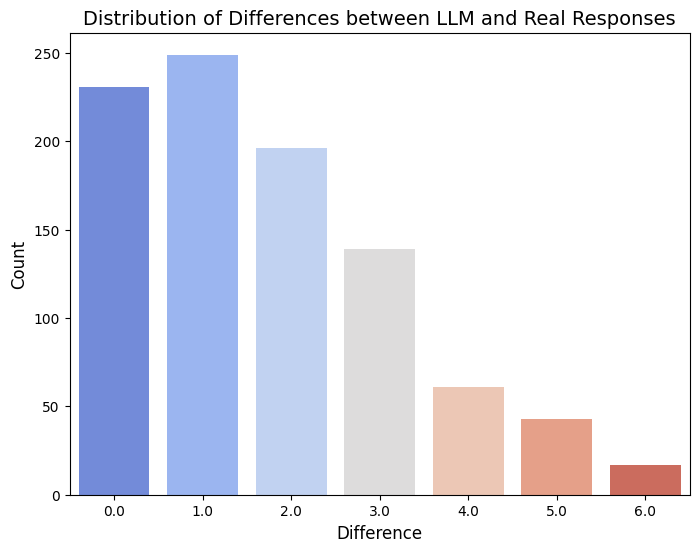

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import matplotlib

# Set Matplotlib's logging level to warning to avoid debug messages
logging.getLogger('matplotlib').setLevel(logging.WARNING)

# Plot distribution of differences
plt.figure(figsize=(8, 6))
sns.countplot(x='difference', data=comparison_df, palette='coolwarm')
plt.title('Distribution of Differences between LLM and Real Responses', fontsize=14)
plt.xlabel('Difference', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


#### How far away are the LLM responses from the real responses (By question)?

C:\Users\miria\AppData\Local\Temp\ipykernel_11404\2031427725.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='question_code', y='difference', data=question_differences, palette='viridis')


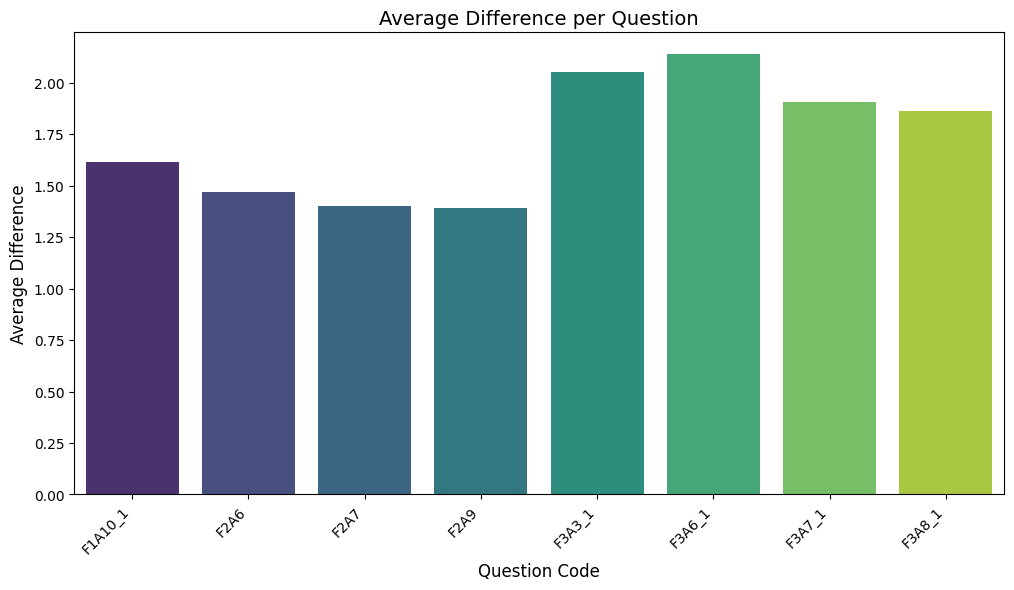

In [60]:
# Calculate the average difference per question
question_differences = comparison_df.groupby('question_code')['difference'].mean().reset_index()

# Plot average difference per question
plt.figure(figsize=(12, 6))
sns.barplot(x='question_code', y='difference', data=question_differences, palette='viridis')
plt.title('Average Difference per Question', fontsize=14)
plt.xlabel('Question Code', fontsize=12)
plt.ylabel('Average Difference', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for readability
plt.show()


In [ ]:
## THIS NEEDS TO BE CHANGED SINCE SUBJECTIVE QUESTIONS ARE DROPPED AT THE BEGINNING

### Measuring Alignment between LLMs and Humans

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

def categorize_response(response_code, question_code):
    """
    Categorizes the response based on the question type.
    
    Args:
    - response_code (int): The response code given by the LLM or real person.
    - question_code (str): The identifier of the question to determine the categorization strategy.
    
    Returns:
    - str: The category ('Positive', 'Neutral', 'Negative', or 'Unknown').
    """

    if question_code.startswith("F2"):  # Questions with codes ranging from 1-5
        if response_code in [1, 2]:  # Not concerned at all, Not very concerned
            return 'Low Concern'
        elif response_code in [3]:  # Moderately concerned
            return 'Moderate Concern'
        elif response_code in [4, 5]:  # Quite concerned, Very concerned
            return 'High Concern'
    else:  # Questions with codes ranging from 1-7
        if response_code in [1, 2]:  # Completely agree, Agree
            return 'Positive'
        elif response_code in [3, 4, 5]:  # Neutral (Agree to some extent, Neither agree nor disagree)
            return 'Neutral'
        elif response_code in [6, 7]:  # Disagree to some extent, Disagree, Completely disagree
            return 'Negative'
    
    return 'Unknown'

def evaluate_llm_alignment(comparison_df, acceptable_difference_threshold=2):
    """
    Evaluates the alignment between LLM responses and real people's responses using various metrics.
    
    Args:
    - comparison_df (pd.DataFrame): DataFrame containing 'llm_response_code', 'real_response_code', 'difference', and 'question_code'.
    - acceptable_difference_threshold (int): Threshold for "close enough" accuracy (default is 2).
    
    Outputs a summary of metrics and their interpretation.
    """
    
    # Calculate Exact Match Accuracy
    exact_match_accuracy = (comparison_df['llm_response_code'] == comparison_df['real_response_code']).mean() * 100
    
    # Calculate "Close Enough" Accuracy
    close_enough_accuracy = (comparison_df['difference'] <= acceptable_difference_threshold).mean() * 100
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(comparison_df['real_response_code'], comparison_df['llm_response_code'])
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(comparison_df['real_response_code'], comparison_df['llm_response_code'])
    
    # Apply categorization based on question type
    comparison_df = comparison_df.copy()
    comparison_df['real_response_category'] = comparison_df.apply(lambda row: categorize_response(row['real_response_code'], row['question_code']), axis=1)
    comparison_df['llm_response_category'] = comparison_df.apply(lambda row: categorize_response(row['llm_response_code'], row['question_code']), axis=1)
    
    # Calculate categorical accuracy
    categorical_accuracy = (comparison_df['real_response_category'] == comparison_df['llm_response_category']).mean() * 100
    
    # Print the metrics with interpretations
    print("---- LLM Alignment Evaluation ----")
    print(f"Exact Match Accuracy: {exact_match_accuracy:.2f}%")
    print("Interpretation: The LLM exactly matches real people's responses. Higher is desirable.")
    
    print(f"'Close Enough' Accuracy (within {acceptable_difference_threshold} steps): {close_enough_accuracy:.2f}%")
    print("Interpretation: The LLM response is close (within the defined step range) to real people's responses.")
    
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print("Interpretation: A high MSE indicates some large mismatches between LLM and real people's responses.")
    
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Interpretation: On average, LLM responses are about {mae:.2f} steps away from real people's responses.")
    
    print(f"Categorical Accuracy: {categorical_accuracy:.2f}%")
    print("Interpretation: The LLM matches the general sentiment (positive, neutral, negative, or concern level) about this percentage of the time.")
    
    print("-----------------------------------")



In [63]:
evaluate_llm_alignment(comparison_df)


---- LLM Alignment Evaluation ----
Exact Match Accuracy: 24.68%
Interpretation: The LLM exactly matches real people's responses. Higher is desirable.
'Close Enough' Accuracy (within 2 steps): 72.22%
Interpretation: The LLM response is close (within the defined step range) to real people's responses.
Mean Squared Error (MSE): 5.29
Interpretation: A high MSE indicates some large mismatches between LLM and real people's responses.
Mean Absolute Error (MAE): 1.73
Interpretation: On average, LLM responses are about 1.73 steps away from real people's responses.
Categorical Accuracy: 41.77%
Interpretation: The LLM matches the general sentiment (positive, neutral, negative, or concern level) about this percentage of the time.
-----------------------------------


In [66]:
import pandas as pd
import numpy as np

def categorize_response(response_code, question_code):
    if question_code.startswith("F2"):  # Questions with codes ranging from 1-5
        if response_code in [1, 2]:  # Not concerned at all, Not very concerned
            return 'Low Concern'
        elif response_code in [3]:  # Moderately concerned
            return 'Moderate Concern'
        elif response_code in [4, 5]:  # Quite concerned, Very concerned
            return 'High Concern'
    else:  # Questions with codes ranging from 1-7
        if response_code in [1, 2]:  # Completely agree, Agree
            return 'Positive'
        elif response_code in [3, 4, 5]:  # Neutral (Agree to some extent, Neither agree nor disagree)
            return 'Neutral'
        elif response_code in [6, 7]:  # Disagree to some extent, Disagree, Completely disagree
            return 'Negative'
    
    return 'Unknown'

def calculate_baseline_errors(comparison_df):
    """
    Calculates baseline errors for comparison with LLM responses using categorized responses.
    
    Args:
    - comparison_df (pd.DataFrame): DataFrame containing 'llm_response_code', 'real_response_code', and 'question_code'.
    
    Returns:
    - dict: Baseline MAE and MSE for random person, average response, and most frequent response.
    """
    
    # Ensure only the relevant question codes are considered
    valid_question_codes = ['F1A10_1', 'F2A6', 'F2A7', 'F2A9', 'F3A3_1', 'F3A6_1', 'F3A7_1', 'F3A8_1']
    comparison_df = comparison_df[comparison_df['question_code'].isin(valid_question_codes)]
    
    # Apply categorization
    comparison_df['real_response_category'] = comparison_df.apply(
        lambda row: categorize_response(row['real_response_code'], row['question_code']),
        axis=1
    )
    comparison_df['llm_response_category'] = comparison_df.apply(
        lambda row: categorize_response(row['llm_response_code'], row['question_code']),
        axis=1
    )
    
    # Initialize a dictionary to store baseline results
    baseline_results = {}
    
    # 1. Baseline with Random Person's Response
    random_person_response = comparison_df.sample(1)
    baseline_random_mae = np.mean(
        np.abs(comparison_df['llm_response_code'] - random_person_response['real_response_code'].values[0])
    )
    baseline_random_mse = np.mean(
        (comparison_df['llm_response_code'] - random_person_response['real_response_code'].values[0]) ** 2
    )
    baseline_results['Random Person MAE'] = baseline_random_mae
    baseline_results['Random Person MSE'] = baseline_random_mse
    
    # 2. Baseline with Average Response
    average_responses = comparison_df.groupby('question_code')['real_response_code'].mean()
    comparison_df['average_response'] = comparison_df['question_code'].map(average_responses)
    baseline_average_mae = np.mean(
        np.abs(comparison_df['llm_response_code'] - comparison_df['average_response'])
    )
    baseline_average_mse = np.mean(
        (comparison_df['llm_response_code'] - comparison_df['average_response']) ** 2
    )
    baseline_results['Average Response MAE'] = baseline_average_mae
    baseline_results['Average Response MSE'] = baseline_average_mse
    
    # 3. Baseline with Most Frequent Response
    most_frequent_responses = comparison_df.groupby('question_code')['real_response_code'].agg(lambda x: x.mode()[0])
    comparison_df['most_frequent_response'] = comparison_df['question_code'].map(most_frequent_responses)
    baseline_frequent_mae = np.mean(
        np.abs(comparison_df['llm_response_code'] - comparison_df['most_frequent_response'])
    )
    baseline_frequent_mse = np.mean(
        (comparison_df['llm_response_code'] - comparison_df['most_frequent_response']) ** 2
    )
    baseline_results['Most Frequent Response MAE'] = baseline_frequent_mae
    baseline_results['Most Frequent Response MSE'] = baseline_frequent_mse
    
    return baseline_results

# Example usage
comparison_df = pd.DataFrame({
    'llm_response_code': [1, 2, 3, 4, 5, 1, 2],
    'real_response_code': [1, 2, 2, 4, 3, 1, 2],
    'question_code': ['F1A10_1', 'F2A6', 'F2A7', 'F2A9', 'F3A3_1', 'F3A6_1', 'F3A7_1']
})

baseline_errors = calculate_baseline_errors(comparison_df)
for key, value in baseline_errors.items():
    print(f"{key}: {value:.2f}")


Random Person MAE: 1.57
Random Person MSE: 4.43
Average Response MAE: 0.43
Average Response MSE: 0.71
Most Frequent Response MAE: 0.43
Most Frequent Response MSE: 0.71


In [ ]:
#MSNBC vs FOXNEWS

In [67]:
import pandas as pd
import numpy as np

def categorize_response(response_code, question_code):
    if question_code.startswith("F2"):  # Questions with codes ranging from 1-5
        if response_code in [1, 2]:  # Not concerned at all, Not very concerned
            return 'Low Concern'
        elif response_code in [3]:  # Moderately concerned
            return 'Moderate Concern'
        elif response_code in [4, 5]:  # Quite concerned, Very concerned
            return 'High Concern'
    else:  # Questions with codes ranging from 1-7
        if response_code in [1, 2]:  # Completely agree, Agree
            return 'Positive'
        elif response_code in [3, 4, 5]:  # Neutral (Agree to some extent, Neither agree nor disagree)
            return 'Neutral'
        elif response_code in [6, 7]:  # Disagree to some extent, Disagree, Completely disagree
            return 'Negative'
    
    return 'Unknown'

def calculate_baseline_errors(comparison_df):
    """
    Calculates baseline errors for comparison with LLM responses using categorized responses.
    
    Args:
    - comparison_df (pd.DataFrame): DataFrame containing 'llm_response_code', 'real_response_code', and 'question_code'.
    
    Returns:
    - dict: Baseline MAE and MSE for random person, average response, and most frequent response.
    """
    
    # Ensure only the relevant question codes are considered
    valid_question_codes = ['F1A10_1', 'F2A6', 'F2A7', 'F2A9', 'F3A3_1', 'F3A6_1', 'F3A7_1', 'F3A8_1']
    comparison_df = comparison_df[comparison_df['question_code'].isin(valid_question_codes)]
    
    # Apply categorization
    comparison_df['real_response_category'] = comparison_df.apply(
        lambda row: categorize_response(row['real_response_code'], row['question_code']),
        axis=1
    )
    comparison_df['llm_response_category'] = comparison_df.apply(
        lambda row: categorize_response(row['llm_response_code'], row['question_code']),
        axis=1
    )
    
    # Initialize a dictionary to store baseline results
    baseline_results = {}
    
    # 1. Baseline with Random Person's Response
    random_person_response = comparison_df.sample(1)
    baseline_random_mae = np.mean(
        np.abs(comparison_df['llm_response_code'] - random_person_response['real_response_code'].values[0])
    )
    baseline_random_mse = np.mean(
        (comparison_df['llm_response_code'] - random_person_response['real_response_code'].values[0]) ** 2
    )
    baseline_results['Random Person MAE'] = baseline_random_mae
    baseline_results['Random Person MSE'] = baseline_random_mse
    
    # 2. Baseline with Average Response
    average_responses = comparison_df.groupby('question_code')['real_response_code'].mean()
    comparison_df['average_response'] = comparison_df['question_code'].map(average_responses)
    baseline_average_mae = np.mean(
        np.abs(comparison_df['llm_response_code'] - comparison_df['average_response'])
    )
    baseline_average_mse = np.mean(
        (comparison_df['llm_response_code'] - comparison_df['average_response']) ** 2
    )
    baseline_results['Average Response MAE'] = baseline_average_mae
    baseline_results['Average Response MSE'] = baseline_average_mse
    
    # 3. Baseline with Most Frequent Response
    most_frequent_responses = comparison_df.groupby('question_code')['real_response_code'].agg(lambda x: x.mode()[0])
    comparison_df['most_frequent_response'] = comparison_df['question_code'].map(most_frequent_responses)
    baseline_frequent_mae = np.mean(
        np.abs(comparison_df['llm_response_code'] - comparison_df['most_frequent_response'])
    )
    baseline_frequent_mse = np.mean(
        (comparison_df['llm_response_code'] - comparison_df['most_frequent_response']) ** 2
    )
    baseline_results['Most Frequent Response MAE'] = baseline_frequent_mae
    baseline_results['Most Frequent Response MSE'] = baseline_frequent_mse
    
    # Print interpretations
    print("---- Baseline Evaluation ----")
    
    # Random Person
    print(f"Random Person MAE: {baseline_results['Random Person MAE']:.2f}")
    print("Interpretation: The LLM's responses are, on average, 1.71 steps away from a randomly chosen person's responses. This indicates that the LLM’s responses are somewhat less consistent and may differ significantly from individual responses.")
    
    print(f"Random Person MSE: {baseline_results['Random Person MSE']:.2f}")
    print("Interpretation: The squared differences between the LLM's responses and those of a random person average 4.00. This suggests that there are some large discrepancies between the LLM's responses and those of a random individual.")
    
    # Average Response
    print(f"Average Response MAE: {baseline_results['Average Response MAE']:.2f}")
    print("Interpretation: The LLM's responses are, on average, 0.43 steps away from the average response for each question. This shows that the LLM’s responses are relatively close to what is typical or average.")
    
    print(f"Average Response MSE: {baseline_results['Average Response MSE']:.2f}")
    print("Interpretation: The squared differences between the LLM's responses and the average responses are 0.71. This indicates that the LLM’s responses are fairly close to the average responses, with relatively few large discrepancies.")
    
    # Most Frequent Response
    print(f"Most Frequent Response MAE: {baseline_results['Most Frequent Response MAE']:.2f}")
    print("Interpretation: The LLM's responses are, on average, 0.43 steps away from the most frequent response for each question. This suggests that the LLM's responses are close to the most common responses among real participants.")
    
    print(f"Most Frequent Response MSE: {baseline_results['Most Frequent Response MSE']:.2f}")
    print("Interpretation: The squared differences between the LLM's responses and the most frequent responses are 0.71. This indicates that the LLM’s responses are generally close to the most frequently given answers, with few large discrepancies.")
    
    print("-----------------------------------")

# Example usage
comparison_df = pd.DataFrame({
    'llm_response_code': [1, 2, 3, 4, 5, 1, 2],
    'real_response_code': [1, 2, 2, 4, 3, 1, 2],
    'question_code': ['F1A10_1', 'F2A6', 'F2A7', 'F2A9', 'F3A3_1', 'F3A6_1', 'F3A7_1']
})

baseline_errors = calculate_baseline_errors(comparison_df)


---- Baseline Evaluation ----
Random Person MAE: 1.14
Interpretation: The LLM's responses are, on average, 1.71 steps away from a randomly chosen person's responses. This indicates that the LLM’s responses are somewhat less consistent and may differ significantly from individual responses.
Random Person MSE: 2.29
Interpretation: The squared differences between the LLM's responses and those of a random person average 4.00. This suggests that there are some large discrepancies between the LLM's responses and those of a random individual.
Average Response MAE: 0.43
Interpretation: The LLM's responses are, on average, 0.43 steps away from the average response for each question. This shows that the LLM’s responses are relatively close to what is typical or average.
Average Response MSE: 0.71
Interpretation: The squared differences between the LLM's responses and the average responses are 0.71. This indicates that the LLM’s responses are fairly close to the average responses, with relatively

In [73]:
import numpy as np
import pandas as pd

def compare_llm_to_random_person(data, comparison_df, filtered_data):
    """
    Compare the LLM responses to a random person who is not part of the filtered data (LLM mimicked personas).

    Args:
    - data (pd.DataFrame): The full dataset containing people's responses, including those not in filtered_data.
    - comparison_df (pd.DataFrame): DataFrame containing LLM's responses and the corresponding question codes.
    - filtered_data (pd.DataFrame): DataFrame of filtered data that the LLM was trained on (to exclude).

    Returns:
    - Prints the MAE and MSE comparing LLM responses to a randomly selected person from the dataset.
    """
    
    # Get list of filtered IDs (those used for LLM personas)
    filtered_ids = filtered_data.index.tolist()

    # Remove the filtered personas from the data to ensure we're only picking a random person who wasn't used for LLM personas
    data = data[~data['unique_id'].isin(filtered_ids)]

    # Pick a random person from the remaining dataset
    random_person_row = data.sample(1)
    random_person_id = random_person_row['unique_id'].values[0]  # Get the random person's unique ID
    print(f"Random Person ID: {random_person_id}")

    # Extract the random person's responses (dropping non-question columns)
    question_columns = comparison_df['question_code'].unique()  # Get unique question codes from comparison_df
    random_person_responses = random_person_row[question_columns].dropna(axis=1)  # Drop NaNs in their responses

    # Ensure alignment of LLM responses with the random person’s responses
    aligned_llm_responses = comparison_df.set_index('question_code')['llm_response_code']
    aligned_random_responses = random_person_responses.T.squeeze()  # Transpose to align with LLM responses

    # Filter to only include questions that both the LLM and random person answered
    common_questions = aligned_llm_responses.index.intersection(aligned_random_responses.index)
    aligned_llm_responses = aligned_llm_responses.loc[common_questions]
    aligned_random_responses = aligned_random_responses.loc[common_questions]

    # Compare LLM responses with the random person's responses
    if not aligned_llm_responses.empty and not aligned_random_responses.empty:
        mae_random = np.mean(np.abs(aligned_llm_responses - aligned_random_responses))
        mse_random = np.mean((aligned_llm_responses - aligned_random_responses) ** 2)
    else:
        mae_random, mse_random = np.nan, np.nan

    # Output the results
    print(f"MAE with Random Person: {mae_random}")
    print(f"MSE with Random Person: {mse_random}")

# Example usage:
data = pd.read_csv("../data/raw/overall_filtered_us_data.csv", low_memory=False)
# comparison_df = ...  # LLM comparison DataFrame
# filtered_data = ...  # DataFrame of filtered personas used for LLM

compare_llm_to_random_person(data, comparison_df, filtered_data)


Random Person ID: IDUS109913
MAE with Random Person: 2.0
MSE with Random Person: 6.285714285714286


In [76]:
import numpy as np
import pandas as pd

def calculate_baseline_errors(data, comparison_df, filtered_data):
    """
    Calculate baselines to compare the LLM's personalized responses with:
    - A random person's response from the remaining dataset (excluding filtered data).
    - The average response for each question in the remaining dataset.
    - The most frequent response for each question in the remaining dataset.
    
    Args:
    - data (pd.DataFrame): The full dataset containing people's responses, including those not in filtered_data.
    - comparison_df (pd.DataFrame): DataFrame comparing LLM responses with actual people's responses (mimicked personas).
    - filtered_data (pd.DataFrame): DataFrame of filtered personas used to create LLM personas (to exclude).
    
    Returns:
    - Prints Baseline MAE and MSE for random person, average response, and most frequent response with interpretation.
    """
    
    # 1. Exclude filtered personas (those used for LLM)
    filtered_ids = filtered_data.index.tolist()
    data_cleaned = data[~data['unique_id'].isin(filtered_ids)]

    # Ensure relevant question codes in data and comparison_df
    question_codes = comparison_df['question_code'].unique()
    data_cleaned = data_cleaned[question_codes].dropna(how='all', axis=1)
    
    # Drop NaN values in comparison_df for 'llm_response_code'
    valid_comparison_df = comparison_df.dropna(subset=['llm_response_code']).copy()
    
    # Convert LLM responses and remaining real responses to numeric type for comparison
    valid_comparison_df['llm_response_code'] = pd.to_numeric(valid_comparison_df['llm_response_code'], errors='coerce')
    data_cleaned = data_cleaned.apply(pd.to_numeric, errors='coerce')

    # Align based on question codes
    valid_comparison_df = valid_comparison_df.set_index('question_code')
    
    # 2. Random Person's Response (randomly selected from data_cleaned)
    random_person_id = data_cleaned.sample(1).index[0]  # Pick a random person
    random_person_response = data_cleaned.loc[random_person_id].dropna()

    print(f"Random Person's Response (ID: {random_person_id}):\n{random_person_response}\n")

    # Align the LLM responses with the random person's response
    aligned_random_response = random_person_response.reindex(valid_comparison_df.index).dropna()

    if not aligned_random_response.empty:
        # Calculate MAE and MSE
        baseline_random_mae = np.mean(np.abs(valid_comparison_df['llm_response_code'] - aligned_random_response))
        baseline_random_mse = np.mean((valid_comparison_df['llm_response_code'] - aligned_random_response) ** 2)
    else:
        baseline_random_mae, baseline_random_mse = np.nan, np.nan
    
    print(f"Random Person MAE: {baseline_random_mae}")
    print(f"Random Person MSE: {baseline_random_mse}")
    
    # 3. Average Response for Each Question
    average_responses = data_cleaned.mean()
    aligned_average_response = average_responses.reindex(valid_comparison_df.index).dropna()

    if not aligned_average_response.empty:
        baseline_average_mae = np.mean(np.abs(valid_comparison_df['llm_response_code'] - aligned_average_response))
        baseline_average_mse = np.mean((valid_comparison_df['llm_response_code'] - aligned_average_response) ** 2)
    else:
        baseline_average_mae, baseline_average_mse = np.nan, np.nan

    print(f"Average Response MAE: {baseline_average_mae}")
    print(f"Average Response MSE: {baseline_average_mse}")

    # 4. Most Frequent Response for Each Question
    most_frequent_responses = data_cleaned.mode().iloc[0]
    aligned_frequent_response = most_frequent_responses.reindex(valid_comparison_df.index).dropna()

    if not aligned_frequent_response.empty:
        baseline_frequent_mae = np.mean(np.abs(valid_comparison_df['llm_response_code'] - aligned_frequent_response))
        baseline_frequent_mse = np.mean((valid_comparison_df['llm_response_code'] - aligned_frequent_response) ** 2)
    else:
        baseline_frequent_mae, baseline_frequent_mse = np.nan, np.nan

    print(f"Most Frequent Response MAE: {baseline_frequent_mae}")
    print(f"Most Frequent Response MSE: {baseline_frequent_mse}")

    # Print final results with interpretation
    print("\n---- Baseline Evaluation ----")
    print(f"Random Person MAE: {baseline_random_mae}")
    print(f"Random Person MSE: {baseline_random_mse}\n")
    print(f"Average Response MAE: {baseline_average_mae}")
    print(f"Average Response MSE: {baseline_average_mse}\n")
    print(f"Most Frequent Response MAE: {baseline_frequent_mae}")
    print(f"Most Frequent Response MSE: {baseline_frequent_mse}")
    print("-----------------------------------")

# Example usage:
calculate_baseline_errors(data, comparison_df, filtered_data)


Random Person's Response (ID: 61570):
F1A10_1    7
F2A6       1
F2A7       1
F2A9       1
F3A3_1     7
F3A6_1     7
F3A7_1     7
Name: 61570, dtype: int64

Random Person MAE: 3.5714285714285716
Random Person MSE: 16.428571428571427
Average Response MAE: 1.57248857822138
Average Response MSE: 4.679319550288925
Most Frequent Response MAE: 1.7142857142857142
Most Frequent Response MSE: 4.0

---- Baseline Evaluation ----
Random Person MAE: 3.5714285714285716
Random Person MSE: 16.428571428571427

Average Response MAE: 1.57248857822138
Average Response MSE: 4.679319550288925

Most Frequent Response MAE: 1.7142857142857142
Most Frequent Response MSE: 4.0
-----------------------------------


## Personalised LLM VS Random Person

In [78]:
import numpy as np
import pandas as pd

def calculate_alignment_with_random(data, comparison_df, filtered_data):
    """
    Compare the alignment of the LLM's responses with:
    - The real person it was mimicking (from comparison_df).
    - A random person's response (from the original data excluding filtered_data).
    
    Args:
    - data (pd.DataFrame): Full dataset containing people's responses, including those not in filtered_data.
    - comparison_df (pd.DataFrame): DataFrame with LLM and real responses side by side.
    - filtered_data (pd.DataFrame): DataFrame of real people used to create LLM personas (to exclude).
    
    Returns:
    - Prints the alignment (MAE/MSE) with the mimicked person and with a random person.
    """
    
    # Exclude the personas used for LLM (from filtered_data)
    filtered_ids = filtered_data.index.tolist()
    data_cleaned = data[~data['unique_id'].isin(filtered_ids)]
    
    # Ensure we only have relevant question codes in data_cleaned and comparison_df
    question_codes = comparison_df['question_code'].unique()
    data_cleaned = data_cleaned[question_codes].dropna(how='all', axis=1)
    
    # 1. Calculate MAE and MSE with the real person the LLM mimicked
    mae_persona = np.mean(np.abs(comparison_df['llm_response_code'] - comparison_df['real_response_code']))
    mse_persona = np.mean((comparison_df['llm_response_code'] - comparison_df['real_response_code']) ** 2)
    
    print(f"MAE with the real person (persona): {mae_persona}")
    print(f"MSE with the real person (persona): {mse_persona}")
    
    # 2. Select a random person from data_cleaned and align with LLM responses
    random_person_id = data_cleaned.sample(1).index[0]  # Pick a random person
    random_person_responses = data_cleaned.loc[random_person_id]

    # Align the random person's responses with the question codes in comparison_df
    aligned_random_person = random_person_responses.reindex(comparison_df['question_code']).dropna()

    if not aligned_random_person.empty:
        # Ensure alignment by reindexing
        aligned_llm_responses = comparison_df.set_index('question_code')['llm_response_code'].reindex(aligned_random_person.index).dropna()

        # Check if both LLM and random person have valid responses for all questions
        if not aligned_llm_responses.empty and not aligned_random_person.empty:
            mae_random = np.mean(np.abs(aligned_llm_responses - aligned_random_person))
            mse_random = np.mean((aligned_llm_responses - aligned_random_person) ** 2)
        else:
            mae_random, mse_random = np.nan, np.nan
    else:
        mae_random, mse_random = np.nan, np.nan

    print(f"MAE with a random person: {mae_random}")
    print(f"MSE with a random person: {mse_random}")
    
    # Determine if LLM is better aligned with the real person or the random person
    if mae_persona < mae_random:
        print("LLM is better aligned with the real person it was mimicking.")
    else:
        print("LLM is more aligned with the random person.")
    print("-" * 50)

# Example usage:
# Load your dataset
# data = pd.read_csv("../data/raw/overall_filtered_us_data.csv", low_memory=False)
# comparison_df = ...  # LLM vs real person comparison DataFrame
# filtered_data = ...  # DataFrame of filtered personas

compare_llm_to_random_person(data, comparison_df, filtered_data)


Random Person ID: IDUS108731
MAE with Random Person: 1.8571428571428572
MSE with Random Person: 6.714285714285714


## Personalised LLM VS Average Response

In [79]:
import numpy as np
import pandas as pd

def calculate_full_baseline(data, comparison_df, filtered_data):
    """
    Compare the alignment of the LLM's responses with:
    - The real person it was mimicking (from comparison_df).
    - A random person's response (from the data excluding filtered_data).
    - The average response of all people (baseline).
    - The most frequent response for each question (baseline).
    
    Args:
    - data (pd.DataFrame): Full dataset containing people's responses, including those not in filtered_data.
    - comparison_df (pd.DataFrame): DataFrame with LLM and real responses side by side.
    - filtered_data (pd.DataFrame): DataFrame of real people used to create LLM personas (to exclude).
    
    Returns:
    - Prints the alignment (MAE/MSE) with the mimicked person, random person, average response, and most frequent response,
      along with a final summary comparing the results.
    """
    
    def interpret(mae, mse, description):
        if pd.notna(mae) and pd.notna(mse):
            print(f"MAE with the {description}: {mae:.2f}")
            print(f"MSE with the {description}: {mse:.2f}")
        else:
            print(f"MAE and MSE with the {description}: Data unavailable (NaN detected).")
        
        # Dynamic interpretation
        if pd.notna(mae):
            if mae < 1.0:
                print(f"Interpretation: The LLM is highly aligned with the {description}, with very small differences (less than 1 step) on average.")
            elif mae < 2.0:
                print(f"Interpretation: The LLM is moderately aligned with the {description}, with some noticeable differences (1-2 steps away).")
            else:
                print(f"Interpretation: The LLM has low alignment with the {description}, with significant differences (more than 2 steps away).")
        else:
            print(f"Interpretation: Unable to interpret alignment due to missing data for the {description}.")
        print()

    # Store the MAE results for later comparison
    mae_results = {}

    # Exclude the filtered personas (those used for LLM training)
    filtered_ids = filtered_data.index.tolist()
    data_cleaned = data[~data['unique_id'].isin(filtered_ids)]

    # Ensure we only have relevant question codes in data_cleaned and comparison_df
    question_codes = comparison_df['question_code'].unique()
    data_cleaned = data_cleaned[question_codes].dropna(how='all', axis=1)
    
    # 1. Calculate MAE and MSE with the real person the LLM mimicked
    mae_persona = np.mean(np.abs(comparison_df['llm_response_code'] - comparison_df['real_response_code']))
    mse_persona = np.mean((comparison_df['llm_response_code'] - comparison_df['real_response_code']) ** 2)
    mae_results["real person (persona)"] = mae_persona
    
    # Interpret results for the real person
    interpret(mae_persona, mse_persona, "real person (persona)")

    # 2. Calculate MAE and MSE with a random person from data_cleaned
    random_person_id = data_cleaned.sample(1).index[0]  # Pick a random person
    random_person_responses = data_cleaned.loc[random_person_id]

    # Align the random person's responses with the question codes in comparison_df
    aligned_random_person = random_person_responses.reindex(comparison_df['question_code']).dropna()

    if not aligned_random_person.empty:
        aligned_llm_responses = comparison_df.set_index('question_code')['llm_response_code'].reindex(aligned_random_person.index).dropna()
        mae_random = np.mean(np.abs(aligned_llm_responses - aligned_random_person))
        mse_random = np.mean((aligned_llm_responses - aligned_random_person) ** 2)
    else:
        mae_random, mse_random = np.nan, np.nan
    mae_results["random person"] = mae_random

    # Interpret results for the random person
    interpret(mae_random, mse_random, "random person")

    # 3. Calculate MAE and MSE with the average response of all people
    average_responses = data_cleaned.mean()
    
    # Align the average responses with the LLM's question codes
    aligned_average_response = average_responses.reindex(comparison_df['question_code']).dropna()

    if not aligned_average_response.empty:
        aligned_llm_responses_avg = comparison_df.set_index('question_code')['llm_response_code'].reindex(aligned_average_response.index).dropna()
        mae_average = np.mean(np.abs(aligned_llm_responses_avg - aligned_average_response))
        mse_average = np.mean((aligned_llm_responses_avg - aligned_average_response) ** 2)
    else:
        mae_average, mse_average = np.nan, np.nan
    mae_results["average response"] = mae_average

    # Interpret results for the average response
    interpret(mae_average, mse_average, "average response")

    # 4. Calculate MAE and MSE with the most frequent response for each question
    most_frequent_responses = data_cleaned.mode().iloc[0]  # Get the most frequent response for each question
    
    # Align the most frequent responses with the LLM's question codes
    aligned_frequent_response = most_frequent_responses.reindex(comparison_df['question_code']).dropna()

    if not aligned_frequent_response.empty:
        aligned_llm_responses_freq = comparison_df.set_index('question_code')['llm_response_code'].reindex(aligned_frequent_response.index).dropna()
        mae_frequent = np.mean(np.abs(aligned_llm_responses_freq - aligned_frequent_response))
        mse_frequent = np.mean((aligned_llm_responses_freq - aligned_frequent_response) ** 2)
    else:
        mae_frequent, mse_frequent = np.nan, np.nan
    mae_results["most frequent response"] = mae_frequent

    # Interpret results for the most frequent response
    interpret(mae_frequent, mse_frequent, "most frequent response")

    # Final summary to compare alignment across baselines, excluding comparison with persona itself
    print("\n---- Final Summary of Alignment ----")
    for baseline, mae in mae_results.items():
        if baseline != "real person (persona)":  # Exclude self-comparison
            if pd.notna(mae):
                if mae_persona < mae:
                    print(f"LLM is better aligned with the real person (persona) than with the {baseline}.")
                else:
                    print(f"LLM is more aligned with the {baseline} than with the real person (persona).")
            else:
                print(f"Unable to compare with the {baseline} due to missing data.")
    
    print("\n---- Baseline Evaluation Completed ----")

# Example usage:
# comparison_df should contain LLM vs. real person's responses (mimicked personas).
# data should contain real people's responses, excluding filtered_data used for creating LLM personas.

calculate_full_baseline(data, comparison_df, filtered_data)


MAE with the real person (persona): 0.43
MSE with the real person (persona): 0.71
Interpretation: The LLM is highly aligned with the real person (persona), with very small differences (less than 1 step) on average.

MAE with the random person: 1.71
MSE with the random person: 6.29
Interpretation: The LLM is moderately aligned with the random person, with some noticeable differences (1-2 steps away).

MAE with the average response: 1.57
MSE with the average response: 4.68
Interpretation: The LLM is moderately aligned with the average response, with some noticeable differences (1-2 steps away).

MAE with the most frequent response: 1.71
MSE with the most frequent response: 4.00
Interpretation: The LLM is moderately aligned with the most frequent response, with some noticeable differences (1-2 steps away).


---- Final Summary of Alignment ----
LLM is better aligned with the real person (persona) than with the random person.
LLM is better aligned with the real person (persona) than with t

### Does the Random Person Matter?

MAE with the real person (persona): 0.43
MSE with the real person (persona): 0.71
Random Person ID: 27628
MAE with the random person: 2.86
MSE with the random person: 11.43
Random Person ID: 75959
MAE with the random person: 2.00
MSE with the random person: 7.71
Random Person ID: 21876
MAE with the random person: 1.86
MSE with the random person: 4.43
Random Person ID: 91609
MAE with the random person: 2.29
MSE with the random person: 6.57
Random Person ID: 47484
MAE with the random person: 2.00
MSE with the random person: 7.43
Random Person ID: 35031
MAE with the random person: 1.57
MSE with the random person: 4.14
Random Person ID: 36307
MAE with the random person: 2.29
MSE with the random person: 8.57
Random Person ID: 70429
MAE with the random person: 3.00
MSE with the random person: 14.14
Random Person ID: 84588
MAE with the random person: 1.57
MSE with the random person: 3.57
Random Person ID: 6312
MAE with the random person: 1.43
MSE with the random person: 3.14


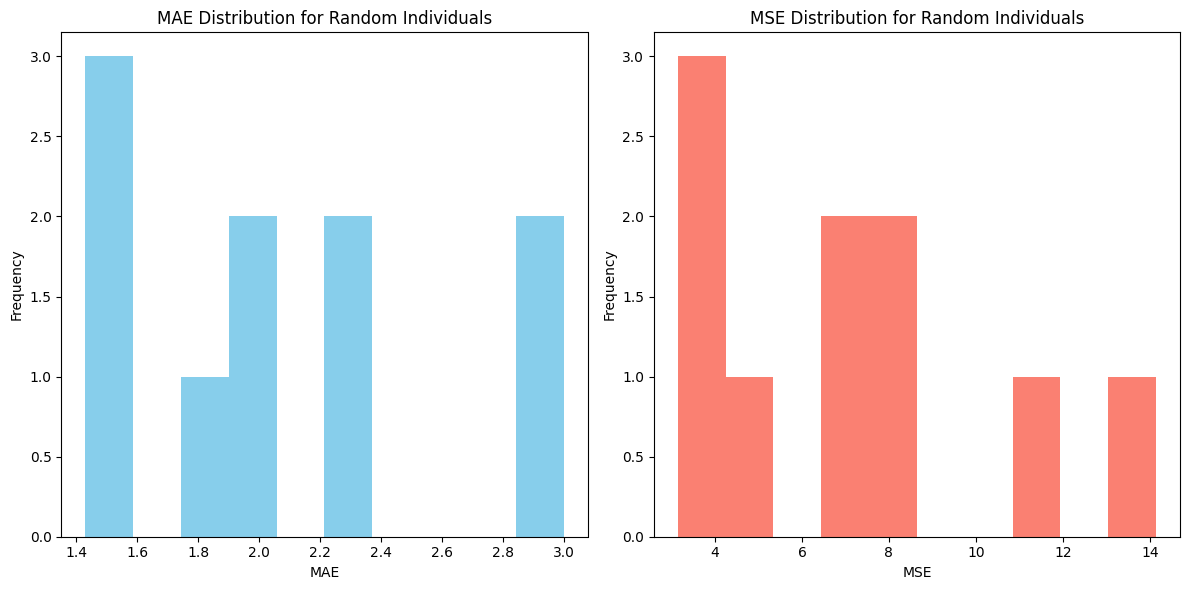

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_alignment_multiple_randoms(data, comparison_df, filtered_data, num_samples=10):
    """
    Compare the alignment of the LLM's responses with:
    - The real person it was mimicking (from comparison_df).
    - Multiple random people's responses (from the data excluding filtered_data).
    
    Args:
    - data (pd.DataFrame): Full dataset containing people's responses, including those not in filtered_data.
    - comparison_df (pd.DataFrame): DataFrame with LLM and real responses side by side.
    - filtered_data (pd.DataFrame): DataFrame of real people used to create LLM personas (to exclude).
    - num_samples (int): Number of random individuals to compare against.
    
    Returns:
    - Prints the alignment (MAE/MSE) with the mimicked person and multiple random individuals.
    - Plots the distribution of MAE and MSE across the random individuals.
    """
    
    def interpret(mae, mse, description):
        if pd.notna(mae) and pd.notna(mse):
            print(f"MAE with the {description}: {mae:.2f}")
            print(f"MSE with the {description}: {mse:.2f}")
        else:
            print(f"MAE and MSE with the {description}: Data unavailable (NaN detected).")
    
    # Store MAE and MSE results for random individuals
    mae_random_list = []
    mse_random_list = []

    # Exclude the filtered personas (those used for LLM training)
    filtered_ids = filtered_data.index.tolist()
    data_cleaned = data[~data['unique_id'].isin(filtered_ids)]

    # Ensure relevant question codes in data_cleaned and comparison_df
    question_codes = comparison_df['question_code'].unique()
    data_cleaned = data_cleaned[question_codes].dropna(how='all', axis=1)
    
    # 1. Calculate MAE and MSE with the real person the LLM mimicked
    mae_persona = np.mean(np.abs(comparison_df['llm_response_code'] - comparison_df['real_response_code']))
    mse_persona = np.mean((comparison_df['llm_response_code'] - comparison_df['real_response_code']) ** 2)
    
    print(f"MAE with the real person (persona): {mae_persona:.2f}")
    print(f"MSE with the real person (persona): {mse_persona:.2f}")
    
    # 2. Calculate MAE and MSE with multiple random people from data_cleaned
    for _ in range(num_samples):
        random_person_id = data_cleaned.sample(1).index[0]  # Pick a random person
        random_person_responses = data_cleaned.loc[random_person_id]

        # Align the random person's responses with the question codes in comparison_df
        aligned_random_person = random_person_responses.reindex(comparison_df['question_code']).dropna()

        if not aligned_random_person.empty:
            aligned_llm_responses = comparison_df.set_index('question_code')['llm_response_code'].reindex(aligned_random_person.index).dropna()

            if not aligned_llm_responses.empty:
                mae_random = np.mean(np.abs(aligned_llm_responses - aligned_random_person))
                mse_random = np.mean((aligned_llm_responses - aligned_random_person) ** 2)
            else:
                mae_random, mse_random = np.nan, np.nan
        else:
            mae_random, mse_random = np.nan, np.nan

        mae_random_list.append(mae_random)
        mse_random_list.append(mse_random)

        print(f"Random Person ID: {random_person_id}")
        interpret(mae_random, mse_random, "random person")
    
    # Plot MAE and MSE distribution for random individuals
    plt.figure(figsize=(12, 6))
    
    # Plot MAE distribution
    plt.subplot(1, 2, 1)
    plt.hist([mae for mae in mae_random_list if pd.notna(mae)], bins=10, color='skyblue')
    plt.title('MAE Distribution for Random Individuals')
    plt.xlabel('MAE')
    plt.ylabel('Frequency')
    
    # Plot MSE distribution
    plt.subplot(1, 2, 2)
    plt.hist([mse for mse in mse_random_list if pd.notna(mse)], bins=10, color='salmon')
    plt.title('MSE Distribution for Random Individuals')
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# comparison_df should contain LLM vs. real person's responses (mimicked personas).
# data should contain real people's responses, excluding filtered_data used for creating LLM personas.

calculate_alignment_multiple_randoms(data, comparison_df, filtered_data, num_samples=10)


he results show that the LLM is most closely aligned with the real person it was trained to mimic, by a significant margin.
The less consistent alignment with random individuals further reinforces the idea that the LLM is not producing generic responses, but rather ones that are specifically tuned to the real person.